# TopoCluster Regression (AutoKeras Edition)

This is a slightly different take on regression than what we've commonly being doing. Instead of making a network that will output the predicted topo-cluster energy, we will make one that will output the predicted *ratio* between true and reco energies.

What's the difference? It might sound like a trivial change, but the ratio is a unitless quantity. So this might help with the problem of having to cover many orders of magnitude in outputs. Now, our "classic" regression networks were dealing with this by performing some scaling of inputs:

$$
\begin{align}
E_\text{reco}  &\rightarrow \ln{ \left (E_\text{reco} \right)} \;, \\
E_\text{truth}  &\rightarrow \ln{ \left (E_\text{truth} \right)} \;\; \text{(target)},
\end{align}
$$

The output of the network, $x$, is then converted to the predicted energy $E_\text{pred}$ via the inverse transformation:

$$
x \rightarrow e^{x} = E_\text{pred}
$$

Thus if there's some small error in $x$, $x \rightarrow x + \delta x$, this may result in a large error in $E_\text{pred}$:

$$
e^{x + \delta x} = e^{\delta x} E_\text{pred} \; .
$$

For example, if we're trying to get an energy of $100 \, \text{[GeV]}$ for a particular cluster, but our network ouput ($x$) is $10\%$ too large, this will lead to a $\sim +50\%$ error in $E_\text{pred}$. (If $x$ is $10\%$ too small, we will have an error of $\sim -40\%$ in $E_\text{pred}$).

-----

In this version of the notebook, we will be using `AutoKeras`. Note that this will require your environment to be set up accordingly (`tensorflow` version of 2.3 or higher). An appropriate environment `ml4p2` is provided in the `\setup\conda` directory.

#### 1) Initial setup

In [1]:
# ML fitting/loading/saving settings
overwriteModel = False # If true, force training. If false, load the specified model if it already exists.

finishTraining = False

Now let's choose our training data (and associated strategy).

In [2]:
# training data choice
# options are jet, pion, pion_reweighted

# options are:
#   - pion_legacy
#   - pion
#   - pion_reweighted

source = 'pion'
subdir = 'pion1a' # name for subdir holding models/plots

In [3]:
# Import some basic libraries.
import sys, os, uuid, glob, pickle, pathlib
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt # used for plotting
#import joblib as jl # for saving scalers
from numba import jit

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu
from util import io_util         as iu

# Custom tensorflow.keras callbacks
from util.keras.callbacks import GetCallbacks

# Regression-specific utils
from util.regression import data_util as rdu
from util.regression import plot_util as rpu
from util.regression import training_util as rtu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression2/Plots/{}/'.format(subdir)
modelpath = path_prefix + 'regression2/Models/{}/'.format(subdir)
paths = [plotpath, modelpath]
for path in [plotpath, modelpath]:
    try: os.makedirs(path)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


In [4]:
# fancy display names for each pion type
pi_latex = {
    'p0': '\(\pi^{0}\)',
    'pp': '\(\pi^{\pm}\)',
}
pi_text = {
    'p0': 'pi0',
    'pp': 'pi+/-'
}

# Plotting settings
# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

#### 2) Get the data.

Let me lay out some definitions, so it's clear as to what the data is.

We have a number of different "strategies" (the `source` variable at the top). These correspond to different choices of training, validation and testing datasets.

1. `pion`: We train and validate the network using our single pion data.

2. `pion_legacy`: We train and validate using our old, noise-free single pion data.

3. `pion_reweighted`: This is the same as `pion`, except that our training data is reweighted using a jet dataset (via their reco topo-cluster $p_T$ distributions), that corresponds with QCD dijet events.

The validation performed for these networks is effectively being done on some "holdout" dataset from training -- it will by definition have similar kinematics, being drawn from the same set of events. The more interesting test -- how our energy regression performs in tandem with classification on our *unlabeled* jet dataset, will be handled in a separate notebook.

In [5]:
if(source == 'pion_legacy'):
    inputpath = path_prefix+'data/pion_legacy/'
    rootfiles = {
        'p0':inputpath + 'pi0.root',
        'pp':inputpath + 'pi[pm]*.root'
    }
    
    branches = ['clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']

elif(source == 'pion' or source == 'pion_reweighted'):
    inputpath=path_prefix+'data/pion/'
    rootfiles = {        
        'p0':inputpath + 'user.mswiatlo.900246.PG_singlepi0_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root',
        'pp':inputpath + 'user.mswiatlo.900247.PG_singlepion_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root'
    }
    
    branches = ['cluster_E', 'cluster_Pt', 'cluster_Eta', 'cluster_ENG_CALIB_TOT']

else: assert(False)

In [6]:
# Prepare data
h5_name_suffix = 'tdata'
h5_name = inputpath + h5_name_suffix

pdata,pcells = mu.setupPionData(
    rootfiles, 
    branches=branches, 
    layers=layers, 
    balance_data=True, 
    n_max = 300000,
    verbose=True,
    load=True,
    save=True,
    filename=h5_name,
    match_distribution='cluster_ENG_CALIB_TOT',
    match_binning = (20000,0.,2000.),
    cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
    cut_values = [.2, (-0.7,0.7)],
    cut_types=['lower','window']
)

total = np.sum([len(x) for x in pdata.values()],dtype=int)
for key,frame in pdata.items():
    n = len(frame)
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=pi_text[key], b = n, c = 100. * n / total))
print("Total: {}".format(total))

# Create/get training/validation/testing indices.
pdata = rdu.DataPrep(pdata,
                     trainfrac=0.7,
                     filename=h5_name
                    )

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/regression2/../data/pion/tdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/regression2/../data/pion/tdata_images.h5.
Number of pi0     events:     300000	(50.0%)
Number of pi+/-   events:     300000	(50.0%)
Total: 600000
Loading indices for key p0 from /local/home/jano/ml4pions/LCStudies/regression2/../data/pion/tdata_indices.h5.
Loading indices for key pp from /local/home/jano/ml4pions/LCStudies/regression2/../data/pion/tdata_indices.h5.


### Defining regression variables

Beyond the information already present in the data, we may want to pre-compute some extra regression inputs.

The difference between computing them here, on the whole dataset, versus doing it in batch as part of the network itself, is that we can also define some `scalers` based on these variables. This will allow us to scale them across the dataset, for example to get them into the interval of \[0,1\].

In [7]:
m = 1.
b = 1.
EnergyMapping = iu.LinLogMapping(b=b,m=m)

It looks like our `LinLogMapping` is pretty numerically stable as long as $b \gg m$. I think this is the expected behaviour, given the instabilities with logarithms that we've seen before.

In [8]:
# Some regression vars.
# Note that the mapping functions can probably be sped up with numba, but might throw errors during plotting above. Need to look into this.
for key,frame in pdata.items():
    frame['logE'] = EnergyMapping.Forward(frame['clusterE'].to_numpy()) # log of reco energy, possible network input
    frame['clusterEtaAbs'] = np.abs(frame['clusterEta'].to_numpy()) # absolute value of eta, possible network input
    #frame['logECalib'] = EnergyMapping.Forward(frame['cluster_ENG_CALIB_TOT'].to_numpy()) # No longer our regression target

    # Now get the ratio of "truth" to reco energy. Be mindful of zeros in denominator
    x = frame['clusterE'].to_numpy()
    x[x==0] = 1.
    frame['ratioE'] = frame['cluster_ENG_CALIB_TOT'].to_numpy() / x

In [9]:
scaler_file = modelpath + 'scalers.save'
scaler_branches = ['logE', 'clusterEtaAbs']
scalers = mu.setupScalers(pdata, scaler_branches, scaler_file)

Loading scalers from /local/home/jano/ml4pions/LCStudies/regression2/../regression2/Models/pion1a/scalers.save.


Let's make plots of any vars that are rescaled using our StandardScalers, to see what the rescaling has done. (We won't put axis labels since the units are kind of funny anyway...)

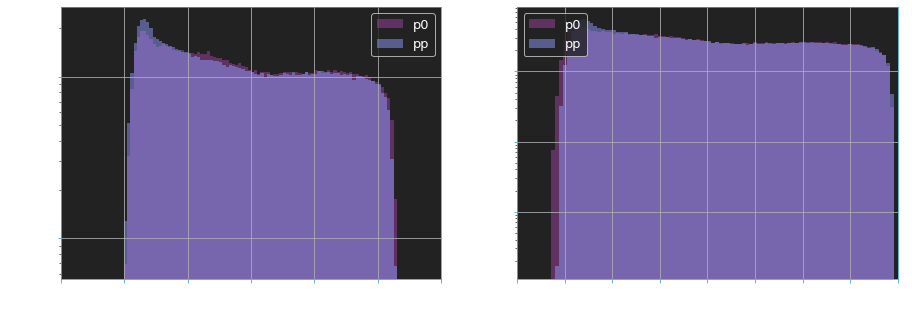

In [10]:
# Let's make a histogram of the regression vars, before and after scaling.
rvars = ['logE', 's_logE']
ranges = {
    'logE':(120,-2.,10.),
    's_logE':(100,-2.,2.)
}
fig, ax = plt.subplots(1,len(rvars),figsize=(7.5 * len(rvars),5))
if(type(ax) != np.ndarray): ax = [ax]

for i,rvar in enumerate(rvars):
    vals = {}
    for key,frame in pdata.items():
        vals[key] = frame[rvar].to_numpy()
    pu.histogramOverlay(ax[i], vals.values(), list(vals.keys()), rvar, 'Fractional count',
                        x_min = ranges[rvar][1], x_max = ranges[rvar][2], xbins = ranges[rvar][0],
                        normed = True, y_log = True,
                        ps = plotstyle
                       )
plt.show()

Let's also make a plot of our regression target, to see what the distribution looks like.

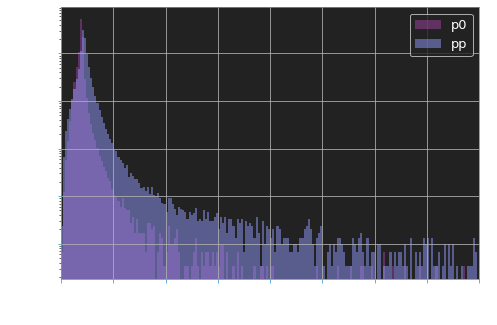

In [11]:
# Let's make a histogram of the regression vars, before and after scaling.
rvars = ['ratioE']
ranges = {
    'ratioE':(200,0.,20.),
}

fig, ax = plt.subplots(1,len(rvars),figsize=(7.5 * len(rvars),5))
if(type(ax) != np.ndarray): ax = [ax]

for i,rvar in enumerate(rvars):
    vals = {}
    for key,frame in pdata.items():
        vals[key] = frame[rvar].to_numpy()
    pu.histogramOverlay(ax[i], vals.values(), list(vals.keys()), rvar, 'Fractional count',
                        x_min = ranges[rvar][1], x_max = ranges[rvar][2], xbins = ranges[rvar][0],
                        normed = True, y_log = True,
                        ps = plotstyle
                       )
plt.show()

As we might have suspected, there is more spread for $\pi^\pm$ than for $\pi^0$. In other words, the charged pion response is worse, and so it will make for a harder regression target. This is consistent with what we've seen elsewhere.

We may optionally perform some re-weighting of our training events. If using the `pion_reweighted` strategy, we will re-weight our single-pion training data to match the topo-cluster $p_T$ spectrum of our jet data.

In [12]:
# TODO: consider re-adding some sample weighting schemes
sample_weights = {
    key: np.full(np.sum(frame['train'].to_numpy()),1.)
    for key,frame in pdata.items()
}

## Tensorflow/AutoKeras Prep

In [13]:
models = {} # keep track of the models
regressors = {} # KerasRegressor wrappers for our models
outputs = {} # keep track of network outputs
energy_ratio_names = {} # keep track of the names of regressed variables

model_filename_suffixes = {
    'pp':'_charged',
    'p0':'_neutral'
}

# desparately trying to get TensorFlow to stop printing useless info -- not sure which lines work, seems to depend on TF version
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # attempt 1
logging.getLogger('tensorflow').setLevel(logging.FATAL) # attempt 2

import tensorflow as tf
import autokeras as atk
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

tf.get_logger().setLevel('INFO')

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2021-06-19 13:20:58.993260: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-06-19 13:20:59.050020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 269.00GiB/s
2021-06-19 13:20:59.050106: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-06-19 13:20:59.052483: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-06-19 13:20:59.054304: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-06-19 13:20:59.054681: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
20

Here's some additional input preparation that we will need for some of our networks.

AutoKeras currently has [issues with accepting multiple image inputs](https://github.com/keras-team/autokeras/issues/1553), so we'll have to stack things into a single multi-channel image (which sort of limits our options and half the reason for using AutoKeras in the first place...).

In [14]:
from util.keras.layers import ImageScaleBlock

# input specifically for autokeras
def ResnetInputAuto(pdata, pcells, layers, dims = (16,16), branch_map={'s_logE':'energy', 's_clusterEtaAbs':'eta'}):
    All_input = rdu.ResnetInput(pdata, pcells, layers = layers, branch_map = branch_map, use_layer_names = True)
    Split_input = rdu.DictionarySplit(All_input, pdata, include_no_split=True)
    
    All_input = {
        key:{} for key in Split_input.keys()
    }
                                        
    for key in All_input.keys():
        
        data_dict = Split_input[key]
        for dkey,data in data_dict.items():
            All_input[key][dkey] = []

            # We need to rescale & concatenate all the images
            ims = [np.expand_dims(data[layer],axis=-1) for layer in layers]
            ims = ImageScaleBlock(new_shape=dims,normalization=True)(ims).numpy()
            All_input[key][dkey].append(ims)
            
            for vkey in data.keys():
                if(vkey not in layers): 
                    
                    # We will be using AutoKeras's "structured input", for which the data must be 2D.
                    # Thus we will reshape our scalar inputs by adding an extra (trivial) dimension.
                    # (This is all because autokeras.Input() does not seem to work with AutoModel, it is not well-supported!).
                    All_input[key][dkey].append(data[vkey].reshape(-1,1)) 
    return All_input

In [15]:
# Some extra prep, to turn our input into a TensorFlow.data.Dataset object.
layers = ['EMB1', 'EMB2','EMB3'] # only use EMB since we have to upscale
All_input = ResnetInputAuto(pdata,pcells, layers = layers)
train_input, valid_input, test_input, All_input = All_input['train'], All_input['val'], All_input['test'], All_input['all']

The cell below is for training. Note that re-running it will possibly overwrite existing networks!

In [ ]:
max_trials=12
nepochs=100
gamma = 0.1
min_delta = 0.0005
patience = 10
overwrite = False # if True, start from scratch, otherwise continue from a pre-existing run

for key in train_input.keys():
    
    model_filename = '{}model_{}.h5'.format(modelpath,key)
    
    print('Running AutoModel for {}.'.format(key))
    
    tidx = pdata[key]['train']
    vidx = pdata[key]['val']
    
    reg = atk.AutoModel(inputs= 1 * [atk.ImageInput()] + 2 * [atk.StructuredDataInput()],
                        outputs= atk.RegressionHead(),
                        project_name = 'auto_model_{}'.format(key),
                        max_trials=max_trials,
                        directory=modelpath,
                        overwrite=overwrite
    )

    x_train = train_input[key]
    y_train = pdata[key]['ratioE'][tidx].to_numpy()
    x_valid = valid_input[key]
    y_valid = pdata[key]['ratioE'][vidx].to_numpy()

    reg.fit(
        x = x_train,
        y = y_train,
        validation_data = [x_valid,y_valid],
        epochs=nepochs,
        callbacks = GetCallbacks(model_filename, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    )
    
    models[key] = reg.export_model()
    models[key].save(model_filename)

In [16]:
# load the networks -- put them in KerasRegressor wrappers, to match our regression code elsewhere.

for key in train_input.keys():
    model_filename = '{}model_{}.h5'.format(modelpath,key)
    print('Loading model for {}.'.format(key))
    models[key] = tf.keras.models.load_model(model_filename, custom_objects=atk.CUSTOM_OBJECTS)
    regressors[key] = KerasRegressor(
        build_fn = models[key],
        batch_size = 200,
        epochs = 100, # doesn't matter 
        verbose = 1 #
    )
    regressors[key].model = models[key]
    
    
    # Now get predictions and save them
    outputs[key] = rtu.GetPredictions(regressor = regressors[key],
                                      model_input = All_input[key],
                                      indices = {k:pdata[key][k].to_numpy() for k in ['train','val','test']},
                                      truth = pdata[key]['cluster_ENG_CALIB_TOT'].to_numpy(),
                                      reco = pdata[key]['clusterE'].to_numpy(),
                                      scaler = None,
                                      mapping = None,
                                      filename = model_filename.replace('.h5','_output.h5')
                                     )

Loading model for p0.
1500/1500 [==============================] - 27s 18ms/step
Loading model for pp.
1500/1500 [==============================] - 28s 19ms/step


2021-06-19 13:21:29.277821: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-06-19 13:21:29.440594: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


In [ ]:
#     pdata[key][energy_ratio_names[model_key]] = rtu.GetPredictions(regressor=regressors[model_key][key],
#                                                                    model_input = All_input[key],
#                                                                    indices = {k:pdata[key][k].to_numpy() for k in ['train','val','test']},
#                                                                    truth = pdata[key]['cluster_ENG_CALIB_TOT'].to_numpy(),
#                                                                    reco = pdata[key]['clusterE'].to_numpy(),
#                                                                    scaler = scalers[key]['logECalib'],
#                                                                    mapping = EnergyMapping,
#                                                                    filename = model_filename.replace('.h5','_output.h5')
#                                                                   )